In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

### task on 30 April 2023
Could use data from the 0.01uM and 10.0uM case to plot curves and then estimate how well these model the illusion of data from 0.1uM and 1.0uM cases?

### Fitting response transcription factor (MFI) concentration with response of Cytokine (%)

TRanscription factor (TF : GATA3 and Tbet) concentration at differnt concentration and cell type were captured. Cytokines (IL-4 and IFNG) % cell response was measured.  These two parameters can be measured with Hill's coefficient. This equation hemps in modeling protein-ligand interaction model.

y = Ymax * [(TF^h)/ (k^h+TF^h)]

Where,
* Y = Cytokine percentage (IFNG/ IL4)
* Ymax = Max(Y)
* TF = Transcription factor (GATA3/Tbet MFI)
* h = Hill's coefficient
* k = Experiment constant

Using the given data, we try to fit a curve and learn the value of h and k

In [2]:
# read daata

df = pd.read_csv("../curatedData/CytoKineexp_Fig4and5.csv")
df.head()

,StimulationType,Concenttration,IFNG,IL4,Tbet,GATA3,G_T
0,WT,0.01,0.3565,10.28,419,1660,4.0
1,WT,0.10,0.9321,4.63,705,591,0.8
2,WT,1.00,5.1620,2.43,1079,470,0.4
3,WT,10.00,11.3090,1.69,1368,359,0.3
4,WT,0.01,0.3685,10.45,421,1612,3.8


In [5]:
df.loc[df[df.Concenttration.isin([0.01,10.00])].index,'sType']="Train"
df.loc[df[df.Concenttration.isin([0.10,1.00])].index,'sType']="Test"
df.groupby(['StimulationType','sType']).size()

StimulationType          sType
IL-4G4/G4 IFNg-/-        Test     6
                         Train    6
IL-4G4/G4 IFNg-/- +IL-4  Test     6
                         Train    6
WT                       Test     6
                         Train    6
WT+IL-4                  Test     6
                         Train    6
dtype: int64

In [3]:
df.groupby("StimulationType").size()

StimulationType
IL-4G4/G4 IFNg-/-          12
IL-4G4/G4 IFNg-/- +IL-4    12
WT                         12
WT+IL-4                    12
dtype: int64

In [6]:
df['IFNG'] = df['IFNG'].astype(float)
df['IL4'] = df['IL4'].astype(float)
df['Tbet'] = df['Tbet'].astype(float)
df['GATA3'] = df['GATA3'].astype(float)
df['G_T'] = df['G_T'].astype(float)

In [7]:
color_map = {"WT":['#a6bddb','#1c9099'],
          "WT+IL-4":['#bcbddc','#756bb1'],
          "IL-4G4/G4 IFNg-/-":['#fdae6b','#e6550d'],
          "IL-4G4/G4 IFNg-/- +IL-4":['#fa9fb5','#c51b8a'], 
         }

In [10]:
# run the model below before running this block
_test = df[(df.StimulationType=="WT")&(df.sType=="Test")]
_train = df[(df.StimulationType=="WT")&(df.sType=="Train")]

<AxesSubplot: xlabel='GATA3', ylabel='IFNG'>

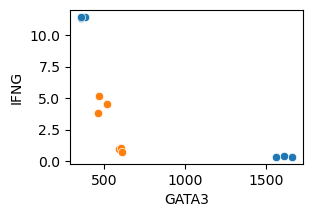

In [23]:
plt.figure(figsize=(3,2))
sns.scatterplot(y='IFNG', x="GATA3",data=_train)
sns.scatterplot(y='IFNG', x="GATA3",data=_test)

-18.17247455225991


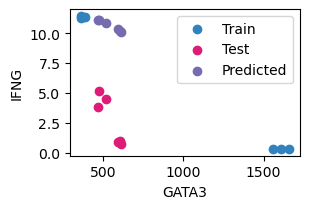

In [31]:
_test = df[(df.StimulationType=="WT")&(df.sType=="Test")]
_train = df[(df.StimulationType=="WT")&(df.sType=="Train")]


popt, pcov = exprHILLeq(_train.GATA3,_train.IFNG)

y_pred = funcHill(_test.GATA3, *(popt))
print (r2_score(_test.IFNG, y_pred))

plt.figure(figsize=(3,2))
plt.scatter(y=_train.IFNG, x=_train.GATA3,label="Train",color="#3182bd")
plt.scatter(y=_test.IFNG, x=_test.GATA3,label="Test",color="#dd1c77")
plt.scatter(_test.GATA3,y_pred,label= "Predicted",color="#756bb1")
plt.legend()
plt.tight_layout()
plt.xlabel("GATA3")
plt.ylabel("IFNG")
plt.show()

In [99]:

# def plotTest(tf,cyto,axs):
tf = 'Tbet'
cyto = 'IFNG'

def getPredictor(simtype, tf, cyto):
    _test = df[(df.StimulationType==simtype)&(df.sType=="Test")]
    _train = df[(df.StimulationType==simtype)&(df.sType=="Train")]
    popt, pcov = exprHILLeq(_train[tf],_train[cyto])

    y_pred = funcHill(_test[tf], *(popt))
    rsquare = round(r2_score(_test[cyto], y_pred),3)
    return [simtype, tf, cyto, rsquare]

def plotPredicted(simtype, tf, cyto,axLoc, legend=1):
    _test = df[(df.StimulationType==simtype)&(df.sType=="Test")]
    _train = df[(df.StimulationType==simtype)&(df.sType=="Train")]
    popt, pcov = exprHILLeq(_train[tf],_train[cyto])

    y_pred = funcHill(_test[tf], *(popt))
    rsquare = round(r2_score(_test[cyto], y_pred),3)
    print (rsquare)

    axLoc.scatter(_train[tf],_train[cyto],color="#3182bd")
    axLoc.scatter(_test[tf],_test[cyto],color="#dd1c77")
    axLoc.scatter(_test[tf],y_pred,label= "{}".format(rsquare),color="#756bb1")
    
    if legend:
        axLoc.legend()
    else:
        axLoc.legend('', frameon=False)
    axLoc.set_xlabel(tf)
    axLoc.set_ylabel(cyto)
    axLoc.set_title(simtype)
    return 1

In [77]:
df.head()

,StimulationType,Concenttration,IFNG,IL4,Tbet,GATA3,G_T,sType
0,WT,0.01,0.3565,10.28,419.0,1660.0,4.0,Train
1,WT,0.10,0.9321,4.63,705.0,591.0,0.8,Train
2,WT,1.00,5.1620,2.43,1079.0,470.0,0.4,Test
3,WT,10.00,11.3090,1.69,1368.0,359.0,0.3,Train
4,WT,0.01,0.3685,10.45,421.0,1612.0,3.8,Train


-19.085
-18.172


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


-1.207


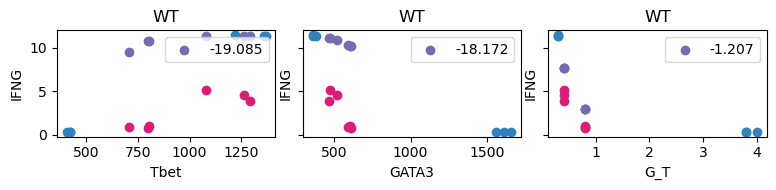

In [100]:
fig, ax = plt.subplots(1,3,figsize=(8,2),sharey=True)
plotPredicted('WT','Tbet','IFNG',ax[0],legend=1)
plotPredicted('WT','GATA3','IFNG',ax[1],legend=1)
plotPredicted('WT','G_T','IFNG',ax[2],legend=1)
plt.tight_layout(w_pad=0.2)
plt.show()

-0.09
-0.893
-0.0


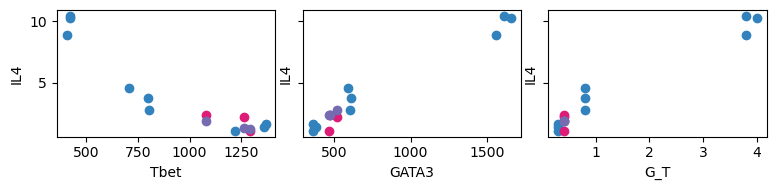

In [79]:
fig, ax = plt.subplots(1,3,figsize=(8,2),sharey=True)
plotPredicted('WT','Tbet','IL4',ax[0],legend=0)
plotPredicted('WT','GATA3','IL4',ax[1],legend=0)
plotPredicted('WT','G_T','IL4',ax[2],legend=0)
plt.tight_layout(w_pad=0.2)
plt.show()

In [63]:
df.groupby("StimulationType").size()

StimulationType
IL-4G4/G4 IFNg-/-          12
IL-4G4/G4 IFNg-/- +IL-4    12
WT                         12
WT+IL-4                    12
dtype: int64

In [83]:
df.loc[df[df.Concenttration.isin([0.01,10.00])].index,'sType']="Train"
df.loc[df[df.Concenttration.isin([0.1,1.00])].index,'sType']="Test"
df.groupby(['StimulationType','sType']).size()

StimulationType          sType
IL-4G4/G4 IFNg-/-        Test     6
                         Train    6
IL-4G4/G4 IFNg-/- +IL-4  Test     6
                         Train    6
WT                       Test     6
                         Train    6
WT+IL-4                  Test     6
                         Train    6
dtype: int64

-0.694
0.201
0.405


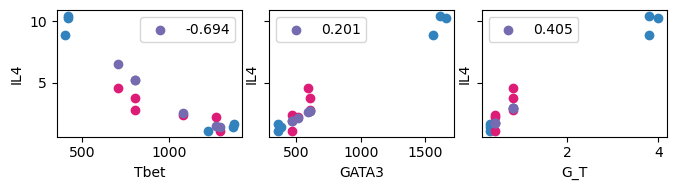

In [87]:
fig, ax = plt.subplots(1,3,figsize=(7,2),sharey=True)
plotPredicted('WT','Tbet','IL4',ax[0],legend=1)
plotPredicted('WT','GATA3','IL4',ax[1],legend=1)
plotPredicted('WT','G_T','IL4',ax[2],legend=1)
plt.tight_layout(w_pad=0.2)
plt.show()

-19.085
-18.172


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


-1.207


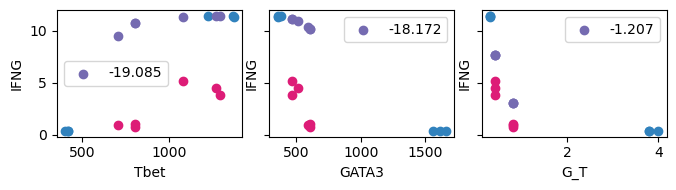

In [89]:
fig, ax = plt.subplots(1,3,figsize=(7,2),sharey=True)
plotPredicted('WT','Tbet','IFNG',ax[0],legend=1)
plotPredicted('WT','GATA3','IFNG',ax[1],legend=1)
plotPredicted('WT','G_T','IFNG',ax[2],legend=1)
plt.tight_layout(w_pad=0.2)
plt.show()

0.268
0.757
0.849


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


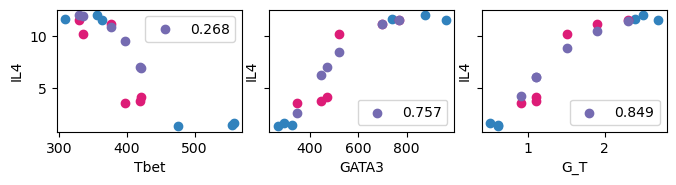

In [98]:


fig, ax = plt.subplots(1,3,figsize=(7,2),sharey=True)
plotPredicted('IL-4G4/G4 IFNg-/-','Tbet','IL4',ax[0],legend=1)
plotPredicted('IL-4G4/G4 IFNg-/-','GATA3','IL4',ax[1],legend=1)
plotPredicted('IL-4G4/G4 IFNg-/-','G_T','IL4',ax[2],legend=1)
plt.tight_layout(w_pad=0.2)
plt.show()

In [94]:
rsquares = []
for k in df.StimulationType.unique():
    try:
        rsquares.append(getPredictor(k,'Tbet','IFNG'))
    except:
        pass
    try:
        rsquares.append(getPredictor(k,'GATA3','IFNG'))
    except:
        pass
    
    try:
        rsquares.append(getPredictor(k,'G_T','IFNG'))
    except:
        pass
    
    try:
        rsquares.append(getPredictor(k,'Tbet','IL4'))
    except:
        pass
    
    try:
        rsquares.append(getPredictor(k,'GATA3','IL4'))
    except:
        pass
    
    try:
        rsquares.append(getPredictor(k,'G_T','IL4'))
    except:
        pass

rsquaresDF = pd.DataFrame(rsquares,columns=['stimulation','TF','Cytokine','rsquare'])

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/Users/khant/miniconda/envs/basePy/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/Users/khant/miniconda/envs/basePy/lib

In [96]:
rsquaresDF[rsquaresDF.rsquare>0]

,stimulation,TF,Cytokine,rsquare
4,WT,GATA3,IL4,0.201
5,WT,G_T,IL4,0.405
14,IL-4G4/G4 IFNg-/-,Tbet,IL4,0.268
15,IL-4G4/G4 IFNg-/-,GATA3,IL4,0.757
16,IL-4G4/G4 IFNg-/-,G_T,IL4,0.849
20,IL-4G4/G4 IFNg-/- +IL-4,Tbet,IL4,0.512


0.268
0.757
0.849


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


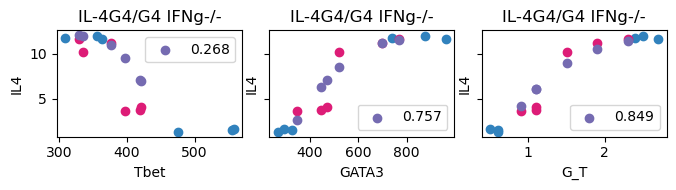

In [101]:
g, ax = plt.subplots(1,3,figsize=(7,2),sharey=True)
plotPredicted('IL-4G4/G4 IFNg-/-','Tbet','IL4',ax[0],legend=1)
plotPredicted('IL-4G4/G4 IFNg-/-','GATA3','IL4',ax[1],legend=1)
plotPredicted('IL-4G4/G4 IFNg-/-','G_T','IL4',ax[2],legend=1)

plt.tight_layout(w_pad=0.2)
plt.show()

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_6347/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


0.512
0.405
0.201


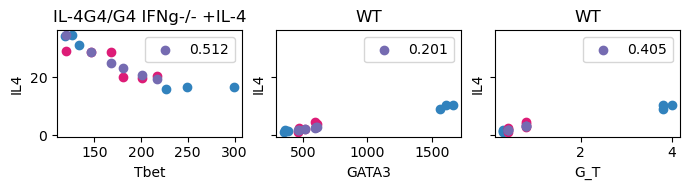

In [104]:
g, ax = plt.subplots(1,3,figsize=(7,2),sharey=True)
plotPredicted('IL-4G4/G4 IFNg-/- +IL-4','Tbet','IL4',ax[0],legend=1)

plotPredicted('WT','G_T','IL4',ax[2],legend=1)
plotPredicted('WT','GATA3','IL4',ax[1],legend=1)


plt.tight_layout(w_pad=0.2)
plt.show()

In [8]:
def funcHill(tf, y_max, k, h):
    return (y_max*(tf**h/(k**h + tf**h)))


def exprHILLeq(xdata, ydata):
    """
    @param:
    xadat : TF
    ydata : cytokine 
    
    @return:
    popt : k and h value
    pcov: covariance matrix: diagonalization will yield CI
    """
    
    p0 = [max(ydata),10,0]
    popt, pcov = curve_fit(funcHill, xdata, ydata, p0,method='lm',maxfev=20000)
    return popt, pcov


def applyEquation(dF, cytokine, TF):
    learned_values = []
    plt.figure(figsize=(4,3))
    for kname, kgrp in dF.groupby("StimulationType"):
        print (kname)
        xdata = kgrp[TF] #['Tbet']
        ydata = kgrp[cytokine] # ['IFNG']
        try:
            popt, pcov = exprHILLeq(xdata,ydata)

            # create test with min and max xdata        
            x_test = np.linspace(min(xdata), max(xdata), 100)
            # predict y-data with learned valy=ue of h and k
            y_pred = funcHill(xdata, *(popt))
            score = r2_score(ydata, y_pred)
            print ("{} : learnt:\nY_max :{}\nK : {} \nh: {}".format(kname, popt[0],popt[1],popt[2]))

            print ("Module R-square value {:.3f}.".format(score))
            # CI
            sigma_ab = np.sqrt(np.diagonal(pcov))
            bound_upper = funcHill(x_test, *(popt + sigma_ab))
            bound_lower = funcHill(x_test, *(popt - sigma_ab))

            learned_values.append([kname, cytokine, TF, score, popt[0],popt[1],popt[2], 'HillCoefficient'])

            #plot
            
            plt.fill_between(x_test, bound_lower, bound_upper,color = color_map[kname][0])
            plt.plot(x_test, funcHill(x_test, *popt),linestyle='--', color= color_map[kname][1],
                     label="{} [{:.3f}]".format(kname, score))
            sns.scatterplot(x=TF,y=cytokine,data=kgrp,color=color_map[kname][1])
            
        except:
            print (kname, "error in fitting")
            sns.scatterplot(x=TF,y=cytokine,data=kgrp,color=color_map[kname][1])
            
    plt.xlabel("{} MFI".format(TF),fontdict={'size':14,'family':'sans-serif'})
    plt.ylabel("% Exprssion {}".format(cytokine), fontdict={'size':14,'family':'sans-serif'})
    plt.tight_layout()
    plt.savefig("../Figures/{}_{}_{}_fit.pdf".format(cytokine, TF, kname.replace("/","_").replace(" ",'')))
    plt.show()
                
    return (learned_values)

In [17]:
df.StimulationType.unique()

array(['WT', 'WT+IL-4', 'IL-4G4/G4 IFNg-/-', 'IL-4G4/G4 IFNg-/- +IL-4'],
      dtype=object)

In [22]:
df_g1 = df[df.StimulationType.isin(['WT', 'WT+IL-4'])]
df_g2 = df[df.StimulationType.isin(['IL-4G4/G4 IFNg-/-', 'IL-4G4/G4 IFNg-/- +IL-4'])]

WT
WT : learnt:
Y_max :23.975868280348323
K : 347.49952747087264 
h: -2.065710462337233
Module R-square value 0.969.
WT+IL-4
WT+IL-4 : learnt:
Y_max :38.872667587343635
K : 819.472109038407 
h: -5.161617891772565
Module R-square value 0.785.


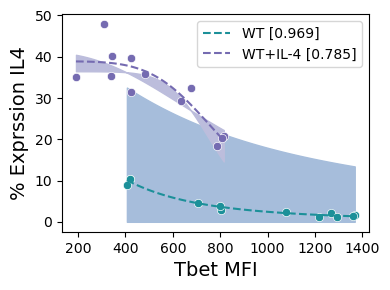

In [23]:
lv = applyEquation(df_g1, "IL4","Tbet")

IL-4G4/G4 IFNg-/-
IL-4G4/G4 IFNg-/- : learnt:
Y_max :11.949261096550504
K : 400.63680288281614 
h: -21.538137125604173
Module R-square value 0.903.
IL-4G4/G4 IFNg-/- +IL-4
IL-4G4/G4 IFNg-/- +IL-4 : learnt:
Y_max :145.14231491037526
K : 38.89890472200675 
h: -1.0801894365381135
Module R-square value 0.881.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


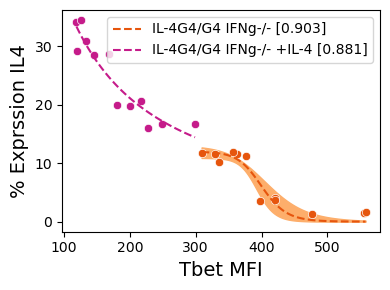

In [24]:
lv = applyEquation(df_g2, "IL4","Tbet")

In [118]:
ylV_tf = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

WT
WT : learnt:
Y_max :11.962099796089484
K : 861.4137982907071 
h: 2.4905291406292083
Module R-square value 0.966.
WT+IL-4
WT+IL-4 : learnt:
Y_max :119.03623369755903
K : 707953877572.382 
h: 0.05012443414054113
Module R-square value 0.000.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


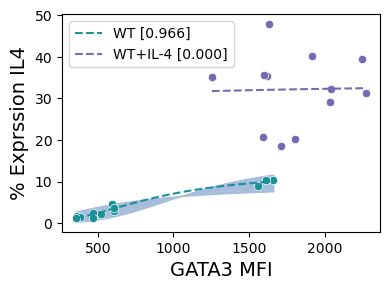

In [25]:
lv = applyEquation(df_g1, "IL4","GATA3")

IL-4G4/G4 IFNg-/-
IL-4G4/G4 IFNg-/- : learnt:
Y_max :12.702208984309
K : 476.4555693900826 
h: 4.839423386644812
Module R-square value 0.930.
IL-4G4/G4 IFNg-/- +IL-4
IL-4G4/G4 IFNg-/- +IL-4 : learnt:
Y_max :25.399741946754613
K : 1132.295910932949 
h: 27.76910519344423
Module R-square value 0.065.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))


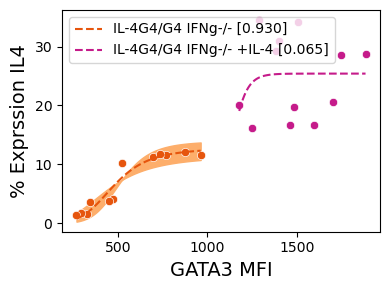

In [30]:
lv = applyEquation(df_g2, "IL4","GATA3")

In [120]:
ylV_il4_gata3 = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

WT
WT : learnt:
Y_max :14.509832958434501
K : 2.016045547256931 
h: 1.1577568676317733
Module R-square value 0.969.
WT+IL-4
WT+IL-4 : learnt:
Y_max :39.443168366687516
K : 2.11189622898056 
h: 3.69465790737138
Module R-square value 0.764.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


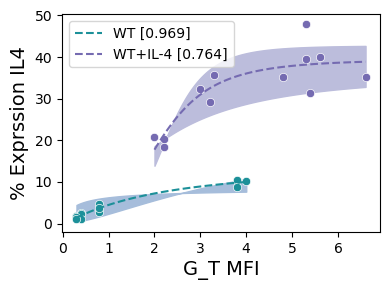

In [31]:
lv = applyEquation(df_g1, "IL4","G_T")

IL-4G4/G4 IFNg-/-
IL-4G4/G4 IFNg-/- : learnt:
Y_max :12.740159242569137
K : 1.2230298457328903 
h: 3.826905891445831
Module R-square value 0.965.
IL-4G4/G4 IFNg-/- +IL-4
IL-4G4/G4 IFNg-/- +IL-4 : learnt:
Y_max :49.11911130049384
K : 8.44435247279654 
h: 1.6936253156162346
Module R-square value 0.869.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


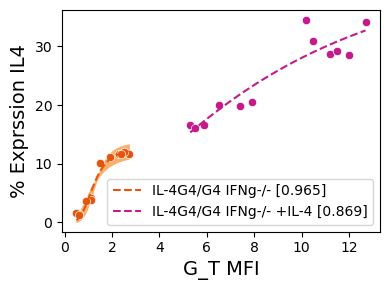

In [26]:
lv = applyEquation(df_g2, "IL4","G_T")
ylV_il4_gt = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

WT
WT : learnt:
Y_max :101973.43571388886
K : 17033.40283836381 
h: 3.6540019280755134
Module R-square value 0.755.
WT+IL-4


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


WT+IL-4 : learnt:
Y_max :1965.6561961626703
K : 0.16259486104704277 
h: -1.4147691441018464
Module R-square value 0.110.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


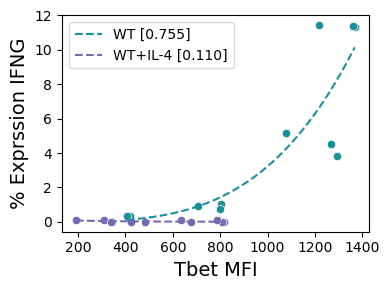

In [27]:
lv = applyEquation(df_g1, "IFNG","Tbet")
ylV_ifng_tbet = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

IL-4G4/G4 IFNg-/-
IL-4G4/G4 IFNg-/- error in fitting
IL-4G4/G4 IFNg-/- +IL-4
IL-4G4/G4 IFNg-/- +IL-4 : learnt:
Y_max :0.15742088945952293
K : 5.29774663302778 
h: 0.38742967153730057
Module R-square value 0.004.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


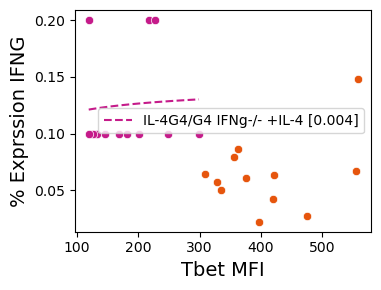

In [32]:
lv = applyEquation(df_g2, "IFNG","Tbet")

WT
WT : learnt:
Y_max :14.560119596174033
K : 432.0644106338459 
h: -7.504974302666095
Module R-square value 0.974.
WT+IL-4
WT+IL-4 : learnt:
Y_max :951.5250087511599
K : 80.16519461641782 
h: -3.3610127306581057
Module R-square value 0.177.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


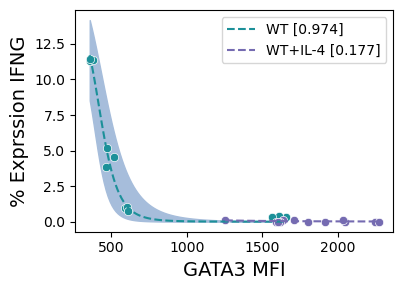

In [33]:
lv = applyEquation(df_g1, "IFNG","GATA3")
ylV_ifng_gata3 = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

<AxesSubplot: xlabel='GATA3', ylabel='IFNG'>

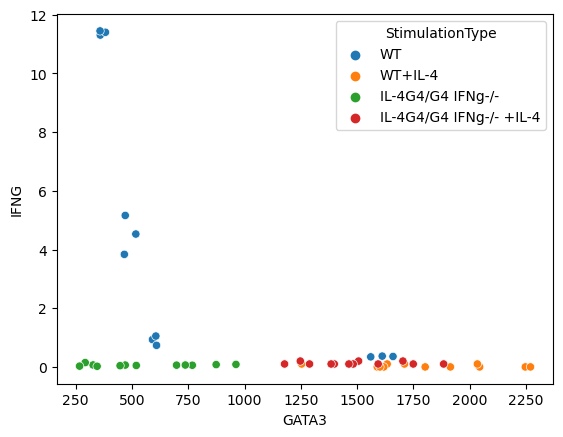

In [88]:
sns.scatterplot(x='GATA3',y='IFNG',data=df,hue='StimulationType')

<AxesSubplot: xlabel='GATA3', ylabel='IFNG'>

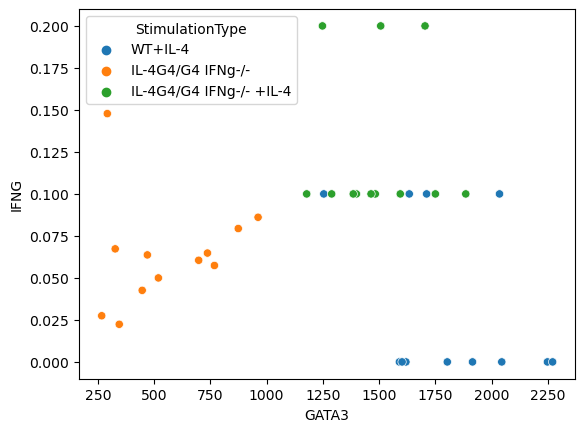

In [131]:
sns.scatterplot(x='GATA3',y='IFNG',data=df[df.StimulationType!="WT"],hue='StimulationType')

WT


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


WT : learnt:
Y_max :1198191.5214924468
K : 0.007150114973956389 
h: -3.095699826433858
Module R-square value 0.992.
WT+IL-4


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


WT+IL-4 : learnt:
Y_max :65.03392252746258
K : 1174997418.7332168 
h: 0.38809907794611387
Module R-square value 0.009.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


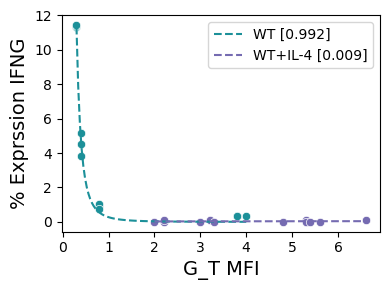

In [29]:
lv = applyEquation(df_g1, "IFNG","G_T")
ylV_ifng_g_t = pd.DataFrame(lv,columns=['StimulationType','Cytokine','TF','R-square','Y_Max','K','h','coefficient'])

IL-4G4/G4 IFNg-/-
IL-4G4/G4 IFNg-/- : learnt:
Y_max :12.846787799852034
K : 6.488021829668592e-30 
h: -0.07851035070256622
Module R-square value 0.007.
IL-4G4/G4 IFNg-/- +IL-4


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


IL-4G4/G4 IFNg-/- +IL-4 : learnt:
Y_max :1.5964189177655987
K : 5.724618922554155e-14 
h: -0.07557545725935104
Module R-square value 0.004.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


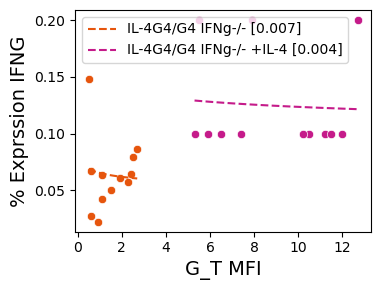

In [34]:
lv = applyEquation(df_g2, "IFNG","G_T")

In [125]:
dxv = pd.concat([ylV_il4_gata3,ylV_il4_gt,ylV_tf,ylV_ifng_g_t,ylV_ifng_gata3,ylV_ifng_tbet],axis=0).reset_index().drop("index",axis=1)

In [126]:
dxv

,StimulationType,Cytokine,TF,R-square,Y_Max,K,h,coefficient
0,IL-4G4/G4 IFNg-/-,IL4,GATA3,0.929871,1.270221e+01,4.764556e+02,4.839423,HillCoefficient
1,IL-4G4/G4 IFNg-/- +IL-4,IL4,GATA3,0.064874,2.539974e+01,1.132296e+03,27.769105,HillCoefficient
2,WT,IL4,GATA3,0.965512,1.196210e+01,8.614138e+02,2.490529,HillCoefficient
3,WT+IL-4,IL4,GATA3,0.000478,1.190362e+02,7.079539e+11,0.050124,HillCoefficient
4,IL-4G4/G4 IFNg-/-,IL4,G_T,0.965488,1.274016e+01,1.223030e+00,3.826906,HillCoefficient
5,IL-4G4/G4 IFNg-/- +IL-4,IL4,G_T,0.869426,4.911911e+01,8.444352e+00,1.693625,HillCoefficient
6,WT,IL4,G_T,0.969380,1.450983e+01,2.016046e+00,1.157757,HillCoefficient
7,WT+IL-4,IL4,G_T,0.763512,3.944317e+01,2.111896e+00,3.694658,HillCoefficient
8,IL-4G4/G4 IFNg-/-,IL4,Tbet,0.902999,1.194926e+01,4.006368e+02,-21.538137,HillCoefficient
9,IL-4G4/G4 IFNg-/- +IL-4,IL4,Tbet,0.880524,1.451423e+02,3.889890e+01,-1.080189,HillCoefficient


In [127]:
dxv.to_csv("../curatedData/stimcondition_result_FItdata_27Feb2023.csv")

In [98]:
import altair as alt

In [115]:
cmap = ['#2c7bb6','#abd9e9','#ffffbf','#fdae61','#d7191c']

alt.Chart(dxv[dxv.StimulationType=="WT"]).mark_point(filled=True).encode(
     x= alt.X("Cytokine"),
     y=alt.Y("TF",sort=['Tbet','GATA3','G_T']),
     size=alt.Size("R-square"),#,scale=alt.Scale(domain=[0.2,0.6,0.9])),
     color=alt.Color("h",scale=alt.Scale(domain=[-4,4],range=cmap,clamp=True))
)

alt.Chart(...)

In [35]:
fig6 = pd.read_csv("../curatedData/data_fig6.csv")

In [36]:
fig6

,Sample:,IFNG+,IL-4+,Tbet MFI,GATA3 MFI,G:T
0,M.A-Group_001-0.01 uM + 0 ng IL-12_Unmixed.fcs,1.48,33.54,203.69,7073.43,34.88
1,M.A-Group_001-0.01 uM + 0.01 ng IL-12_Unmixed.fcs,90.08,0.40,253.31,2046.69,8.10
2,M.A-Group_001-0.01 uM + 0.1 ng IL-12_Unmixed.fcs,97.91,0.08,254.22,2016.10,7.96
3,M.A-Group_001-0.01 uM + 1 ng IL-12_Unmixed.fcs,99.91,0.12,409.60,3749.07,9.16
4,M.A-Group_001-0.01 uM + 10 ng IL-12_Unmixed.fcs,99.87,0.16,443.34,3686.73,8.32
5,M.A-Group_001-0.1 uM + 0 ng IL-12_Unmixed.fcs,1.19,35.73,229.71,7666.79,33.46
6,M.A-Group_001-0.1 uM + 0.01 ng IL-12_Unmixed.fcs,91.03,5.71,336.37,3228.92,0.20
7,M.A-Group_001-0.1 uM + 0.1 ng IL-12_Unmixed.fcs,94.73,0.76,290.55,1705.49,5.89
8,M.A-Group_001-0.1 uM + 1 ng IL-12_Unmixed.fcs,99.40,0.21,409.91,1569.53,3.83
9,M.A-Group_001-0.1 uM + 10 ng IL-12_Unmixed.fcs,99.91,0.55,522.10,2080.93,3.99


In [60]:
color_map = {"points":"#8856a7","ci":"#e0ecf4","line":"#fc9272"}
def applyEquation_fig6(dF, cytokine, TF):
    learned_values = []
    plt.figure(figsize=(4,3))
    xdata = dF[TF] #['Tbet']
    ydata = dF[cytokine] # ['IFNG']
    try:
        popt, pcov = exprHILLeq(xdata,ydata)

        # create test with min and max xdata        
        x_test = np.linspace(min(xdata), max(xdata), 100)
        # predict y-data with learned valy=ue of h and k
        y_pred = funcHill(xdata, *(popt))
        score = r2_score(ydata, y_pred)
        print ("{}~ {} : learnt:\nY_max :{}\nK : {} \nh: {}".format(cytokine, TF, popt[0],popt[1],popt[2]))

        print ("Module R-square value {:.3f}.".format(score))
        # CI
        sigma_ab = np.sqrt(np.diagonal(pcov))
        bound_upper = funcHill(x_test, *(popt + sigma_ab))
        bound_lower = funcHill(x_test, *(popt - sigma_ab))

        learned_values.append([cytokine, TF, score, popt[0],popt[1],popt[2], 'HillCoefficient'])

        #plot

        plt.fill_between(x_test, bound_lower, bound_upper,color = color_map["ci"])
        plt.plot(x_test, funcHill(x_test, *popt),linestyle='--', color= color_map["line"],
                 label="R-sq = {:.3f}]".format(score))
        sns.scatterplot(x=TF,y=cytokine,data=dF,color=color_map["points"])

    except:
        print (cytokine, TF, "error in fitting")
        sns.scatterplot(x=TF,y=cytokine,data=kgrp,color=color_map[kname][1])
            
    plt.xlabel("{} MFI".format(TF),fontdict={'size':14,'family':'sans-serif'})
    plt.ylabel("% Exprssion {}".format(cytokine), fontdict={'size':14,'family':'sans-serif'})
    plt.tight_layout()
    plt.savefig("../Figures/fig6_{}_{}.pdf".format(cytokine, TF))
    plt.show()
                
    return (learned_values)

IFNG+~ Tbet MFI : learnt:
Y_max :97.08357963041941
K : 244.16280607243397 
h: 85.40873180411367
Module R-square value 0.984.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))


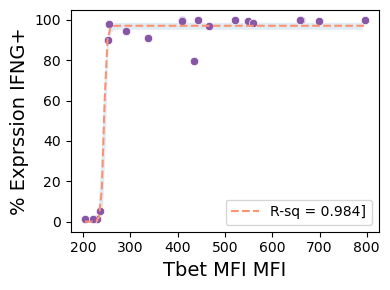

[['IFNG+',
  'Tbet MFI',
  0.9844668939626199,
  97.08357963041941,
  244.16280607243397,
  85.40873180411367,
  'HillCoefficient']]

In [61]:
applyEquation_fig6(fig6, 'IFNG+','Tbet MFI')

In [57]:
fig6.head()

,Sample:,IFNG+,IL-4+,Tbet MFI,GATA3 MFI,G:T
0,M.A-Group_001-0.01 uM + 0 ng IL-12_Unmixed.fcs,1.48,33.54,203.69,7073.43,34.88
1,M.A-Group_001-0.01 uM + 0.01 ng IL-12_Unmixed.fcs,90.08,0.40,253.31,2046.69,8.10
2,M.A-Group_001-0.01 uM + 0.1 ng IL-12_Unmixed.fcs,97.91,0.08,254.22,2016.10,7.96
3,M.A-Group_001-0.01 uM + 1 ng IL-12_Unmixed.fcs,99.91,0.12,409.60,3749.07,9.16
4,M.A-Group_001-0.01 uM + 10 ng IL-12_Unmixed.fcs,99.87,0.16,443.34,3686.73,8.32


IFNG+~ GATA3 MFI : learnt:
Y_max :91.28300714395525
K : 5455.075628325765 
h: -30.758294422338587
Module R-square value 0.713.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


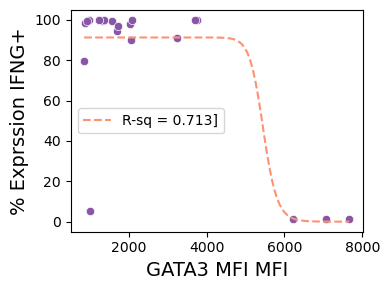

[['IFNG+',
  'GATA3 MFI',
  0.7131188661926824,
  91.28300714395525,
  5455.075628325765,
  -30.758294422338587,
  'HillCoefficient']]

In [62]:
applyEquation_fig6(fig6, 'IFNG+','GATA3 MFI')

IFNG+~ G:T : learnt:
Y_max :91.28339642706231
K : 20.443761439367467 
h: -12.133589053400359
Module R-square value 0.713.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


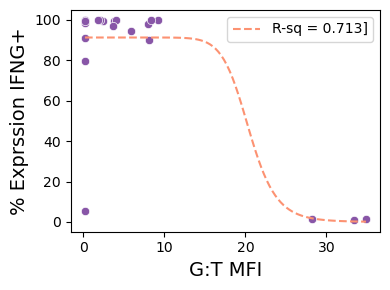

[['IFNG+',
  'G:T',
  0.7131400628952425,
  91.28339642706231,
  20.443761439367467,
  -12.133589053400359,
  'HillCoefficient']]

In [63]:
applyEquation_fig6(fig6, 'IFNG+','G:T')

In [64]:
fig6.head()

,Sample:,IFNG+,IL-4+,Tbet MFI,GATA3 MFI,G:T
0,M.A-Group_001-0.01 uM + 0 ng IL-12_Unmixed.fcs,1.48,33.54,203.69,7073.43,34.88
1,M.A-Group_001-0.01 uM + 0.01 ng IL-12_Unmixed.fcs,90.08,0.40,253.31,2046.69,8.10
2,M.A-Group_001-0.01 uM + 0.1 ng IL-12_Unmixed.fcs,97.91,0.08,254.22,2016.10,7.96
3,M.A-Group_001-0.01 uM + 1 ng IL-12_Unmixed.fcs,99.91,0.12,409.60,3749.07,9.16
4,M.A-Group_001-0.01 uM + 10 ng IL-12_Unmixed.fcs,99.87,0.16,443.34,3686.73,8.32


IL-4+~ GATA3 MFI : learnt:
Y_max :36.22299094754351
K : 6300.6461464718 
h: 21.830210158071942
Module R-square value 0.983.


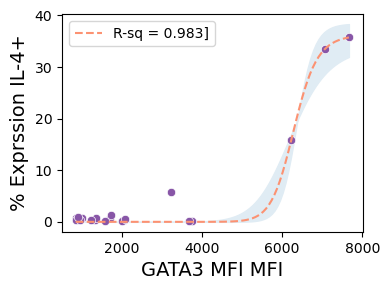

[['IL-4+',
  'GATA3 MFI',
  0.982579097483412,
  36.22299094754351,
  6300.6461464718,
  21.830210158071942,
  'HillCoefficient']]

In [65]:
applyEquation_fig6(fig6, 'IL-4+','GATA3 MFI')

/Users/khant/miniconda/envs/basePy/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))


IL-4+~ Tbet MFI : learnt:
Y_max :28.704769882794555
K : 233.6066615784021 
h: -135.6464306812354
Module R-square value 0.846.


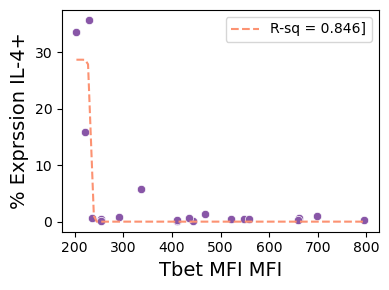

IL-4+~ G:T : learnt:
Y_max :34.63500006296136
K : 28.311734117298478 
h: 115.94291893995276
Module R-square value 0.981.


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in power
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in divide
  return (y_max*(tf**h/(k**h + tf**h)))
/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_46751/4030609492.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (y_max*(tf**h/(k**h + tf**h)))


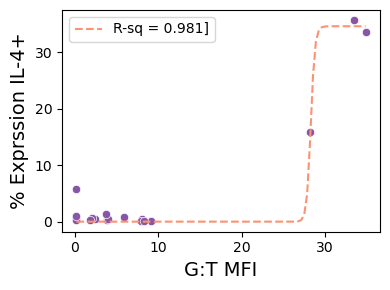

[['IL-4+',
  'G:T',
  0.9814897225324656,
  34.63500006296136,
  28.311734117298478,
  115.94291893995276,
  'HillCoefficient']]

In [66]:
applyEquation_fig6(fig6, 'IL-4+','Tbet MFI')
applyEquation_fig6(fig6, 'IL-4+','G:T')